In [1]:
from sim_env import FixedSimEnv, flag_departure_event
import pandas as pd
import numpy as np
from data_handlers import GTFSHandler, AVLHandler, bpf, write_sim_data, ODXHandler
from itertools import product
from constants import *
import zipfile

In [2]:
# METHOD 1
# np.random.seed(0)
env = FixedSimEnv()
next_obs, rew, done, info = env.reset()
print(env.lines[ROUTES[0]].hist_date)

2022-11-30


In [4]:
# METHOD 2 DON'T RESET DATE
# np.random.seed(0)
next_obs, rew, done, info = env.reset(reset_date=False)
print(env.lines[ROUTES[0]].hist_date)

i = 0
while not done and i < 3000:
    next_obs, rew, done, info = env.step()

    if not done:
        control_veh = flag_departure_event(info)
        if not control_veh.empty:
            if control_veh['status'].iloc[0] == 1:
                print(control_veh[['time', 'status', 'status_desc','stop_id', 'route_id']])

    i += 1

2022-11-30
              time  status                     status_desc  stop_id route_id
29 0 days 06:17:55       1  inactive - terminal turnaround    14108       92


In [ ]:
i = 0
while not done and i < 10000:
    next_obs, rew, done, info = env.step()
    i += 1

In [4]:
stops = gtfs_handler.route_stops.copy()
schedule = gtfs_handler.schedule.copy()
am_schd = schedule[(schedule['arrival_time'].str[:2].isin(['05','06', '07','08', '09']))].copy()
# am_schd[(schedule['stop_sequence']==1)].groupby(['route_id', 'direction', 'shape_id']).size()

for r in ROUTES:
    schd = am_schd[am_schd['route_id']==r].copy()
    for d in schd['direction'].unique():
        schd_d = schd[schd['direction']==d].copy()
        first_stop = schd_d.loc[schd_d['stop_sequence']==1, 'stop_id'].unique()
        last_stop = schd_d.loc[schd_d['stop_sequence']==schd_d['stop_sequence'].max(), 'stop_id'].unique()
        print(f'route {r} direction {d}')
        print(f'first stop {first_stop}')
        print(f'last stop {last_stop}')

In [7]:
sched_df = pd.read_csv('data/sim_data/schedule.csv')
lt_df = pd.read_csv('data/sim_data/link_times.csv')

terminal_df = sched_df[sched_df['stop_sequence']==1].copy()
terminal_df['block_id'] = terminal_df['block_id'].astype(int)

# COUNT BLOCKS AND RUNS
blocks = terminal_df.groupby('block_id')['trip_id'].count().reset_index()
runs = terminal_df.groupby('runid')['trip_id'].count().reset_index()

run_blocks = terminal_df.groupby('runid')['block_id'].median().reset_index() # DUBIOUS WAY TO CLASSIFY
run_blocks['block_id'] = run_blocks['block_id'].astype(int)
run_blocks.sort_values(by='block_id').head(8)

In [50]:
from sim_env import FixedSimEnv, flag_departure_event, recommended_dep_t
import pandas as pd
import numpy as np
from constants import *
from copy import deepcopy
# import matplotlib.pyplot as plt
from utils import plot_situation

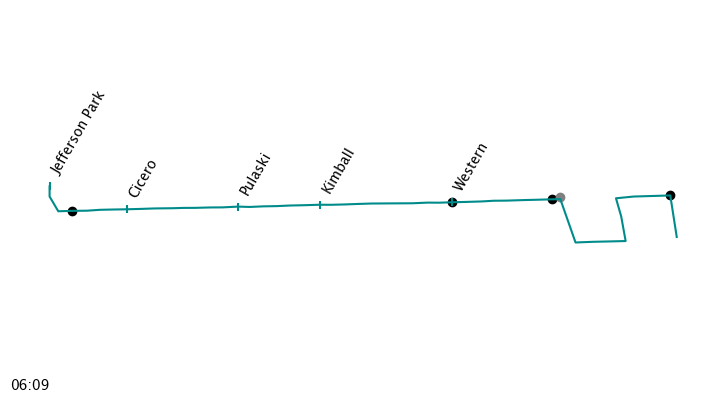

In [46]:
plot_situation(env.info_records[-1], stops_e, key_stops_e)

In [78]:
trip_records = []
for veh in env.vehicles:
    if not veh.trip_records.empty:
        trip_records.append(veh.trip_records)

In [ ]:
env.vehicles[0].trip_records

In [2]:
import pandas as pd

In [10]:
pax_ehd = pd.read_csv('data/sim_out/experiments_0502-1702/EHD/pax.csv')
pax_nc = pd.read_csv('data/sim_out/experiments_0502-1702/NC/pax.csv')

trips_ehd = pd.read_csv('data/sim_out/experiments_0502-1702/EHD/trips.csv')
trips_nc = pd.read_csv('data/sim_out/experiments_0502-1702/NC/trips.csv')

In [56]:
import os
from constants import *
import pandas as pd
from utils import get_results

In [57]:
start_time = 7*60*60
end_time = 9*60*60
res = get_results('0529-1244', ['EHD', 'NC'], start_time, end_time)

In [58]:
res

,metric,EHD,NC,prc_imp
0,wait_t,400.707234,428.567115,-6.50
1,rbt,230.607529,269.710561,-14.50
2,denied,0.000000,0.000000,NaN
3,sd_load_pk_e,12.185454,10.715895,13.71
4,run_time_e_95,3446.030911,3667.399587,-6.04
5,run_time_w_95,3251.998410,3198.981979,1.66
